In [10]:
#Importing libraries
import networkx as nx
import simplejson as sjs
import json as js
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
from networkx.readwrite import json_graph

#### Don't run below cell -- this is just to show how to create a graph using networkx

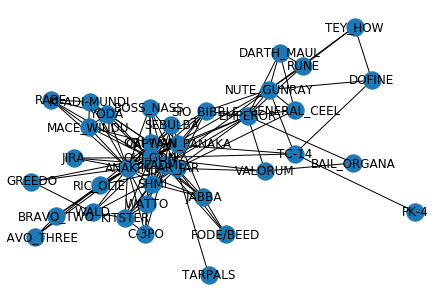

In [95]:
#Networkx plot using the draw function
nx.draw(G,with_labels=True)
#nx.edges(G)
#nx.nodes(G)

## New code to create all networkx JSONs and CSVs all iteratively

In [11]:
# Instantiate the network Graph
G = nx.Graph()

In [12]:
# Derive the edges by crawling the nodes - Newer version of JSON (Updated interactions JSON)
def crawl_new(jsdata):
    tracker = {}
    count = 0
    for key, item in jsdata.items():
        if isinstance(item, list):
            for i in item:
                if "id" in i:
                    tracker[i["id"]] = count
                    count = count + 1
                elif "source" in i:
                    G.add_edge(i['source'], i['target'], weight = i['value'])

In [13]:
def calc_metrics(G):
    dgc = nx.degree_centrality(G) # degree of centrality
    closeness = nx.closeness_centrality(G, u=None, distance=None) # closeness calculation
    betweenness = nx.betweenness_centrality(G, k=None, normalized=True, weight=None, endpoints=False, seed=None) # betweenness calculation
    evcentrality = nx.eigenvector_centrality(G, max_iter=100, tol=1e-06, nstart=None, weight='weight') # Eigen vector centrality calculation
    nodes_list = nx.nodes(G)

    #Converting to pandas dataframe
    dgc_df = pd.DataFrame(list(dgc.items())).rename(columns={0: "character_name", 1: "Degree"})
    closeness_df = pd.DataFrame(list(closeness.items())).rename(columns={0: "character_name", 1: "Closeness"})
    betweenness_df = pd.DataFrame(list(betweenness.items())).rename(columns={0: "character_name", 1: "Betweenness"})
    evc_df = pd.DataFrame(list(evcentrality.items())).rename(columns={0: "character_name", 1: "Eigenvector"})

    #Build network metrics in a tabular format using pandas dataframe
    dataframes = [dgc_df, closeness_df, betweenness_df, evc_df]
    tabular_network_metrics = reduce(lambda left,right: pd.merge(left, right, on=['character_name'], how='inner'), dataframes)

    tabular_network_metrics = tabular_network_metrics.set_index(['character_name'], drop=True)

    tabular_network_metrics['Degree'] = tabular_network_metrics['Degree'].apply(lambda x: round(x, 3))
    tabular_network_metrics['Closeness'] = tabular_network_metrics['Closeness'].apply(lambda x: round(x, 3))
    tabular_network_metrics['Betweenness'] = tabular_network_metrics['Betweenness'].apply(lambda x: round(x, 3))
    tabular_network_metrics['Eigenvector'] = tabular_network_metrics['Eigenvector'].apply(lambda x: round(x, 3))

    # tabular_network_metrics.style.format('{0:,.3f}').highlight_max(color='lightblue')
    
    return tabular_network_metrics
    

In [14]:
interaction_files = ["1", "12", "123"]
for i in interaction_files:
    ### First open the relevant accumulated interaction files i.e. episode 1, then episodes 1 & 2, episodes 1, 2 & 3 and so forth ###
    json_data_new = {}
    with open(f'EDA/star-wars-network-data-master/starwars-episode-{i}-interactions_updated.json') as f:
        json_data_new = js.loads(f.read())

    ### Next, compute graph ###
    G = nx.Graph()
    crawl_new(json_data_new)

    ### Then, network metrics and convert to pandas DF ###
    final_df = calc_metrics(G)

    ### Finally save files  ####
    json_data_with_metrics = json_data_new.copy()
    # final_df = tabular_network_metrics.data
    print(i)

    for node in json_data_with_metrics['nodes']:
        if (node['id'] in final_df.index): # Networkx doesnt include nodes with zero connection in the returned df, so have to check for their existence else you get keyerror
            node['Degree'] = final_df.loc[node['id']]['Degree']
            node['Closeness'] = final_df.loc[node['id']]['Closeness']
            node['Betweenness'] = final_df.loc[node['id']]['Betweenness']
            node['Eigenvector'] = final_df.loc[node['id']]['Eigenvector']

    with open(f'EDA/star-wars-network-data-master/starwars-episode-{i}-interactions_updated_with_metrics.json', 'w', encoding='utf-8') as f:
        f.write(js.dumps(json_data_with_metrics, ensure_ascii=False))

    final_df[sorted(final_df[['Degree', 'Betweenness']])].head(15).to_csv(f'files/tabular_network_metrics_episode{i}.csv')

1
12
123
